In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import skill_metrics as sm
import torch
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from src.dataset import GoncaDataset
from src.model import MLP, AutoEncoder, FinalModule

seaborn.set()

HORIZONS = 12
WINDOW = 3
FORWARD_EXPANSION = 1
N_LAYERS = 1
DECOMP_METHOD = 'fft'
DEVICE = torch.device('cuda')

In [2]:
def plot_taylor(refs: dict, predictions_dict: dict):

    models = list(predictions_dict.keys())
    colors = ['c', 'm', 'y', 'k', 'r', 'b', 'g']
    colors = colors[:len(models)]
    models = {model: color for model, color in zip(models, colors)}
    for idx, (model, pred_dict) in enumerate(predictions_dict.items()):
        taylor_stats = []
        name = model[0]
        for horizon, pred in pred_dict.items():
            taylor_stats.append(sm.taylor_statistics(pred, refs[name][int(horizon)], 'data'))

        sdev = np.array([taylor_stats[0]['sdev'][0]]+[x['sdev'][1]
                                                    for x in taylor_stats])
        crmsd = np.array([taylor_stats[0]['crmsd'][0]]+[x['crmsd'][1]
                                                        for x in taylor_stats])
        ccoef = np.array([taylor_stats[0]['ccoef'][0]]+[x['ccoef'][1]
                                                        for x in taylor_stats])

        # To change other params in the plot, check SkillMetrics documentation in
        # https://github.com/PeterRochford/SkillMetrics/wiki/Target-Diagram-Options
        if len(list(predictions_dict.keys())) != 1:
            if idx != len(list(predictions_dict.keys()))-1 or len(list(predictions_dict.keys())) == 1:
                sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                                colOBS='g', markerobs='o',
                                titleRMS='off',showlabelsRMS = 'off',
                                markercolor=models[model])
            else:
                sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                                titleOBS='Observation',
                                colOBS='g', markerobs='o', markercolor=models[model],
                                overlay = 'on', markerLabel=models)
        else:
            sm.taylor_diagram(sdev, crmsd, ccoef, styleOBS='-',
                      colOBS='g', markerobs='o',
                      titleOBS='Observation', markercolor='c',
                      markerLabel=['placeholder']+[
                          k+1 for k, v in pred_dict.items()])

In [3]:
dataset = GoncaDataset(window=WINDOW,
                           horizons=HORIZONS,
                           data_name='G7',
                           decomp_method=DECOMP_METHOD,
                           decomp=False)

train_loader = DataLoader(dataset, batch_size=128,
                            shuffle=True, num_workers=8)

input_example = next(iter(train_loader))[0]
input_size = input_example.shape[1]*input_example.shape[2]

In [4]:
auto_encoder = AutoEncoder(input_size=input_size,
                               horizons=HORIZONS, device=DEVICE,
                               forward_expansion=FORWARD_EXPANSION,
                               num_layers=N_LAYERS)

trainer = Trainer(gpus=1, max_epochs=5)
trainer.fit(auto_encoder, train_dataloader=train_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mateus/miniconda3/envs/ts/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 878 K 
1 | decoder | Decoder | 1.1 M 
------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
Epoch 4: 100%|██████████| 274/274 [00:07<00:00, 37.27it/s, loss=0.00931, v_num=3, train_loss_step=0.0111, train_loss_epoch=0.00954]


1

In [5]:
final_model = FinalModule(input_size=input_size,
                              horizons=HORIZONS, device=DEVICE,
                              forward_expansion=FORWARD_EXPANSION,
                              num_layers=N_LAYERS)
final_model.load_encoder(auto_encoder.encoder)
final_trainer = Trainer(gpus=1, max_epochs=5)
final_trainer.fit(final_model, train_dataloader=train_loader)
final_model.cuda()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 878 K 
1 | fc_out  | Linear  | 6.2 K 
------------------------------------
6.2 K     Trainable params
878 K     Non-trainable params
884 K     Total params
Epoch 4: 100%|██████████| 274/274 [00:03<00:00, 74.30it/s, loss=0.00748, v_num=4, train_loss_step=0.00866, train_loss_epoch=0.00765]


FinalModule(
  (encoder): Encoder(
    (series_embedding): Linear(in_features=147, out_features=512, bias=True)
    (layers): ModuleList(
      (0): TransformerBlock(
        (attention): SelfAttention(
          (values): Linear(in_features=64, out_features=64, bias=False)
          (keys): Linear(in_features=64, out_features=64, bias=False)
          (queries): Linear(in_features=64, out_features=64, bias=False)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dropout): Dropout(p=0.0, inplace=Fals

In [6]:
mlp = MLP(input_size=input_size, horizons=HORIZONS)
mlp_trainer = Trainer(gpus=1, max_epochs=5)
mlp_trainer.fit(mlp, train_dataloader=train_loader)
mlp.cuda()


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 552   
--------------------------------------
552       Trainable params
0         Non-trainable params
552       Total params
Epoch 4: 100%|██████████| 274/274 [00:03<00:00, 80.32it/s, loss=0.00432, v_num=5, train_loss_step=0.00447, train_loss_epoch=0.00538]


MLP(
  (layers): Sequential(
    (0): Linear(in_features=147, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=12, bias=True)
  )
)

In [7]:
dataset.set_type('test')
X_test = dataset.samples
y = dataset.labels
y_final = final_model(X_test.to(DEVICE)).detach().cpu().numpy()
y_mlp = mlp(X_test.to(DEVICE)).detach().cpu().numpy()
preds = {}
preds['Transformer'] = {i: y_final[:, i] for i in range(HORIZONS)}
preds['MLP'] = {i: y_mlp[:, i] for i in range(HORIZONS)}
refs = {key: {i: y[:, i].numpy() for i in range(HORIZONS)} for key in ['T', 'M']}

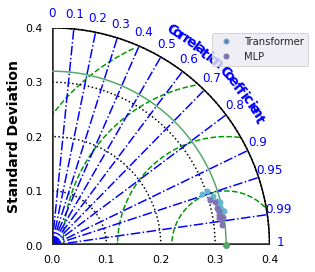

In [8]:
plot_taylor(refs, preds)

plt.show()